Cuda Device Available
Name of the Cuda Device:  NVIDIA GeForce RTX 3060 Laptop GPU
GPU Computational Capablity:  (8, 6)


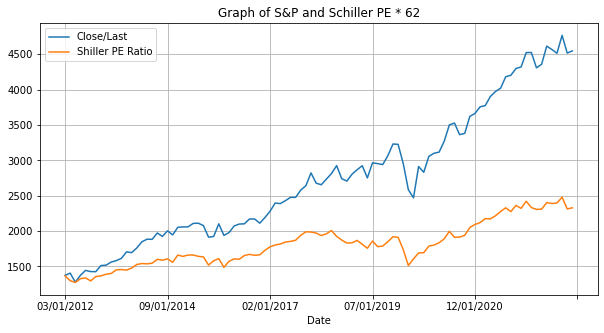

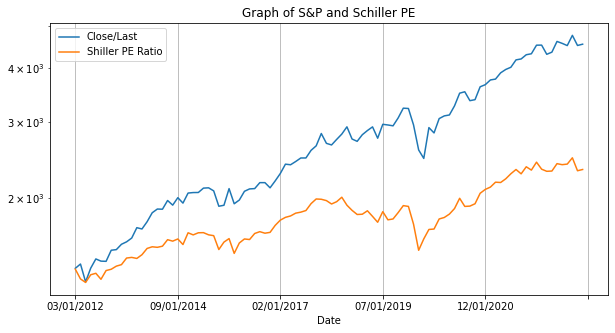

In [3]:
import torch 
from torch import nn
import numpy as np
import math
import pandas as pd
import matplotlib


if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Cuda Device Available")
    print("Name of the Cuda Device: ", torch.cuda.get_device_name())
    print("GPU Computational Capablity: ", torch.cuda.get_device_capability())
    
def ChangeDateShiller(date):
    date = date.split()
    firstElement = date[0]
    firstElement = firstElement.split('-')
    firstElement[0], firstElement[1] = firstElement[1], firstElement[0]
    firstElement[1], firstElement[2] = firstElement[2], firstElement[1]
    if len(firstElement[0]) == 1:
        firstElement[0] = "0" + firstElement
    if len(firstElement[1]) == 1:
        firstElement[1] = "0" + firstElement
    firstElement = "/".join(firstElement)
    return firstElement

#Rough Estimate made Graphically
def MultiplyPE(pe):
    pe = pe * 62
    return pe

#Scales PE for 2012 y intercept
def ScalePERatio(df):
    df['Shiller PE Ratio'] = df['Shiller PE Ratio'].apply(MultiplyPE)
    return df

    
def BuildSandPDataSet():
    df = pd.read_csv("SandP500Data.csv", sep = ',')
    df.drop('Volume', inplace = True, axis=1)
    df = df.sort_index(axis=0,ascending=False).reset_index()
    df.drop('index', inplace = True, axis = 1)
    return df

def BuildShillerPeDataSet():
    df = pd.read_csv("ShillerPERatio.csv", sep = ',', skiprows = [0])
    df = df.rename(columns={'DateTime': 'Date'})
    df['Date'] = df['Date'].apply(ChangeDateShiller)
    return df

def BuildDataset():
    SP = BuildSandPDataSet()
    PE = BuildShillerPeDataSet()
    df = pd.merge(SP, PE, how="inner", on=["Date"])
    return df

def MergeByDate(df1, df2):
    dfinal = df1.merge(df2, on="Date", how = 'inner')
    return dfinal



#Looks like the derivatives of each are correlated
#Even though maybe the magnitudes are not
def GraphPEToClose(SandPData, PEData, logy = False):
    if logy == False:
        PEData = ScalePERatio(PEData)
        title = "Graph of S&P and Schiller PE * 62"
    else:
         title = "Graph of S&P and Schiller PE"
        
    dfinal = MergeByDate(SandPData, PEData)
    dfinal[:].plot(x='Date', y=['Close/Last', 'Shiller PE Ratio'], figsize=(10,5), logy = logy, title = title, grid=True)

    
    
    
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i20 = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    
SP = BuildSandPDataSet()
PE = BuildShillerPeDataSet()

GraphPEToClose(SP, PE)
GraphPEToClose(SP, PE, True)
